# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn import metrics

from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
import optuna

import statsmodels.api as sm
import statsmodels.tools
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import pickle

In [2]:
# load the data
df_original = pd.read_csv("final_dataset.csv")

In [3]:
# fix spelling mistake
df_original.rename(columns = {'occured' : 'occurred'}, inplace = True)

In [4]:
df_original.head()

,daynight_N,lat,lon,fire_weather_index,pressure_mean,wind_direction_mean,wind_direction_std,solar_radiation_mean,dewpoint_mean,cloud_cover_mean,evapotranspiration_total,humidity_min,temp_mean,temp_range,wind_speed_max,occurred,frp
0,0.0,-15.19928,38.54393,5.654271,955.608333,136.083333,43.611845,250.333333,15.883333,18.375000,4.89,35.0,23.175000,12.9,13.5,0.0,3.69
1,1.0,31.51203,-101.57546,16.564673,927.016667,181.333333,31.925260,296.916667,10.529167,3.416667,7.24,16.0,29.733333,13.4,16.2,0.0,0.73
2,1.0,-13.74538,28.05493,5.542089,884.379167,109.166667,8.379870,210.958333,6.095833,12.208333,3.68,35.0,14.104167,11.1,16.8,0.0,0.78
3,0.0,13.53091,-11.22573,7.703410,981.158333,168.416667,133.287570,244.208333,13.095833,56.458333,5.59,29.0,26.704167,12.9,11.0,0.0,8.91
4,0.0,5.61833,16.59892,16.895093,917.116667,202.208333,91.791875,266.750000,6.712500,9.166667,6.00,10.0,26.820833,16.0,16.6,0.0,5.97


The 'frp' column represents Fire Radiative Power, which measures the heat energy released by a fire

We will not be using this column as it is not a widely used variable in wildfire prediction.  

A regression model could be developed using 'frp' as the target column to predict the intensity of the wildfire, but we have focused on a classification model for this project.  

Therefore we can drop this column.  

In [5]:
# drop frp column
df_original.drop(columns = 'frp', inplace = True)

# Initial Exploration

In [6]:
df = df_original.copy()

In [7]:
df_original.shape

(118858, 16)

Check nulls, duplicates, datatypes:

In [8]:
df.isnull().sum()

daynight_N                  0
lat                         0
lon                         0
fire_weather_index          0
pressure_mean               0
wind_direction_mean         0
wind_direction_std          0
solar_radiation_mean        0
dewpoint_mean               0
cloud_cover_mean            0
evapotranspiration_total    0
humidity_min                0
temp_mean                   0
temp_range                  0
wind_speed_max              0
occurred                    0
dtype: int64

In [9]:
df.duplicated().sum()

0

In [10]:
df.dtypes

daynight_N                  float64
lat                         float64
lon                         float64
fire_weather_index          float64
pressure_mean               float64
wind_direction_mean         float64
wind_direction_std          float64
solar_radiation_mean        float64
dewpoint_mean               float64
cloud_cover_mean            float64
evapotranspiration_total    float64
humidity_min                float64
temp_mean                   float64
temp_range                  float64
wind_speed_max              float64
occurred                    float64
dtype: object

Check number of zeros:

In [11]:
# count the number of 0s in each column
number_of_zeros = (df==0).sum()

# Create a dataframe to display this
zeros = pd.DataFrame(number_of_zeros, columns = ['number of zeros'])

# calculate the percentage of the column that these zero values take up
percent = round((number_of_zeros / len(df))*100, 2)

# Add this to the dataframe
zeros['percentage of zeros'] = percent

## Return the calculations in descending order
zeros.sort_values('percentage of zeros', ascending = False)

,number of zeros,percentage of zeros
daynight_N,101073,85.04
occurred,59406,49.98
cloud_cover_mean,10465,8.80
solar_radiation_mean,6,0.01
evapotranspiration_total,9,0.01
lat,0,0.00
lon,0,0.00
fire_weather_index,0,0.00
pressure_mean,0,0.00
wind_direction_mean,0,0.00


> daynight_N and occurred are binary columns so the 0s are fine

> cloud_cover_mean measures the percentage cloud cover over a 1 hour period, so this can be 0

In [12]:
# check how many negative entries there are in each column

df[df < 0].count()

daynight_N                      0
lat                         65562
lon                         34299
fire_weather_index            199
pressure_mean                   0
wind_direction_mean             0
wind_direction_std              0
solar_radiation_mean            0
dewpoint_mean               16496
cloud_cover_mean                0
evapotranspiration_total        0
humidity_min                    0
temp_mean                     199
temp_range                      0
wind_speed_max                  0
occurred                        0
dtype: int64

* lat and lon can have negative values
* temperature can be negative so temp_mean can have negative values
* dewpoint can also be negative, so dewpoint_mean can have negative values
* fire weather index CANNOT be less than 0, so these must be errors.

In [13]:
# dropping the rows that are <0 in fire_weather_index

df = df[df['fire_weather_index']>=0]

# EDA

### Investigating Target Variable

Check class balance:

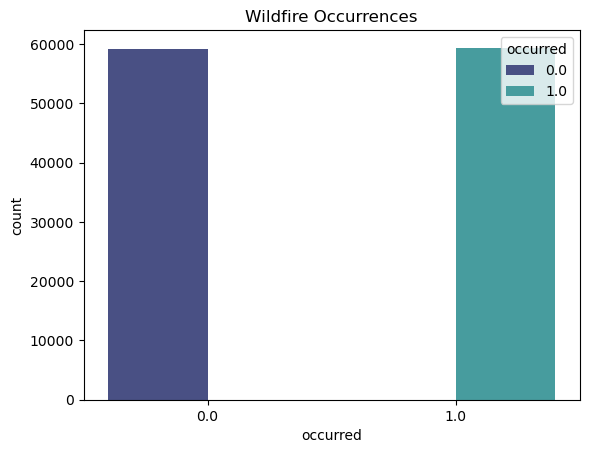

In [14]:
# check proportion of 0s to 1s

df['occurred'].value_counts()

sns.countplot(data=df
              ,x='occurred'      # count the wildfires/no wildfires
              ,palette='mako'    # set the colour palette
              ,hue='occurred'    # colour the graphs
             )

# Add a title to the graph
plt.title('Wildfire Occurrences')

# Display the graph
plt.show()

# Correlations

We can investigate the relationships between columns by creating a pairplot.

In [15]:
# sns.pairplot(df)

We can show just some relevant columns below.

<Figure size 2000x2000 with 0 Axes>

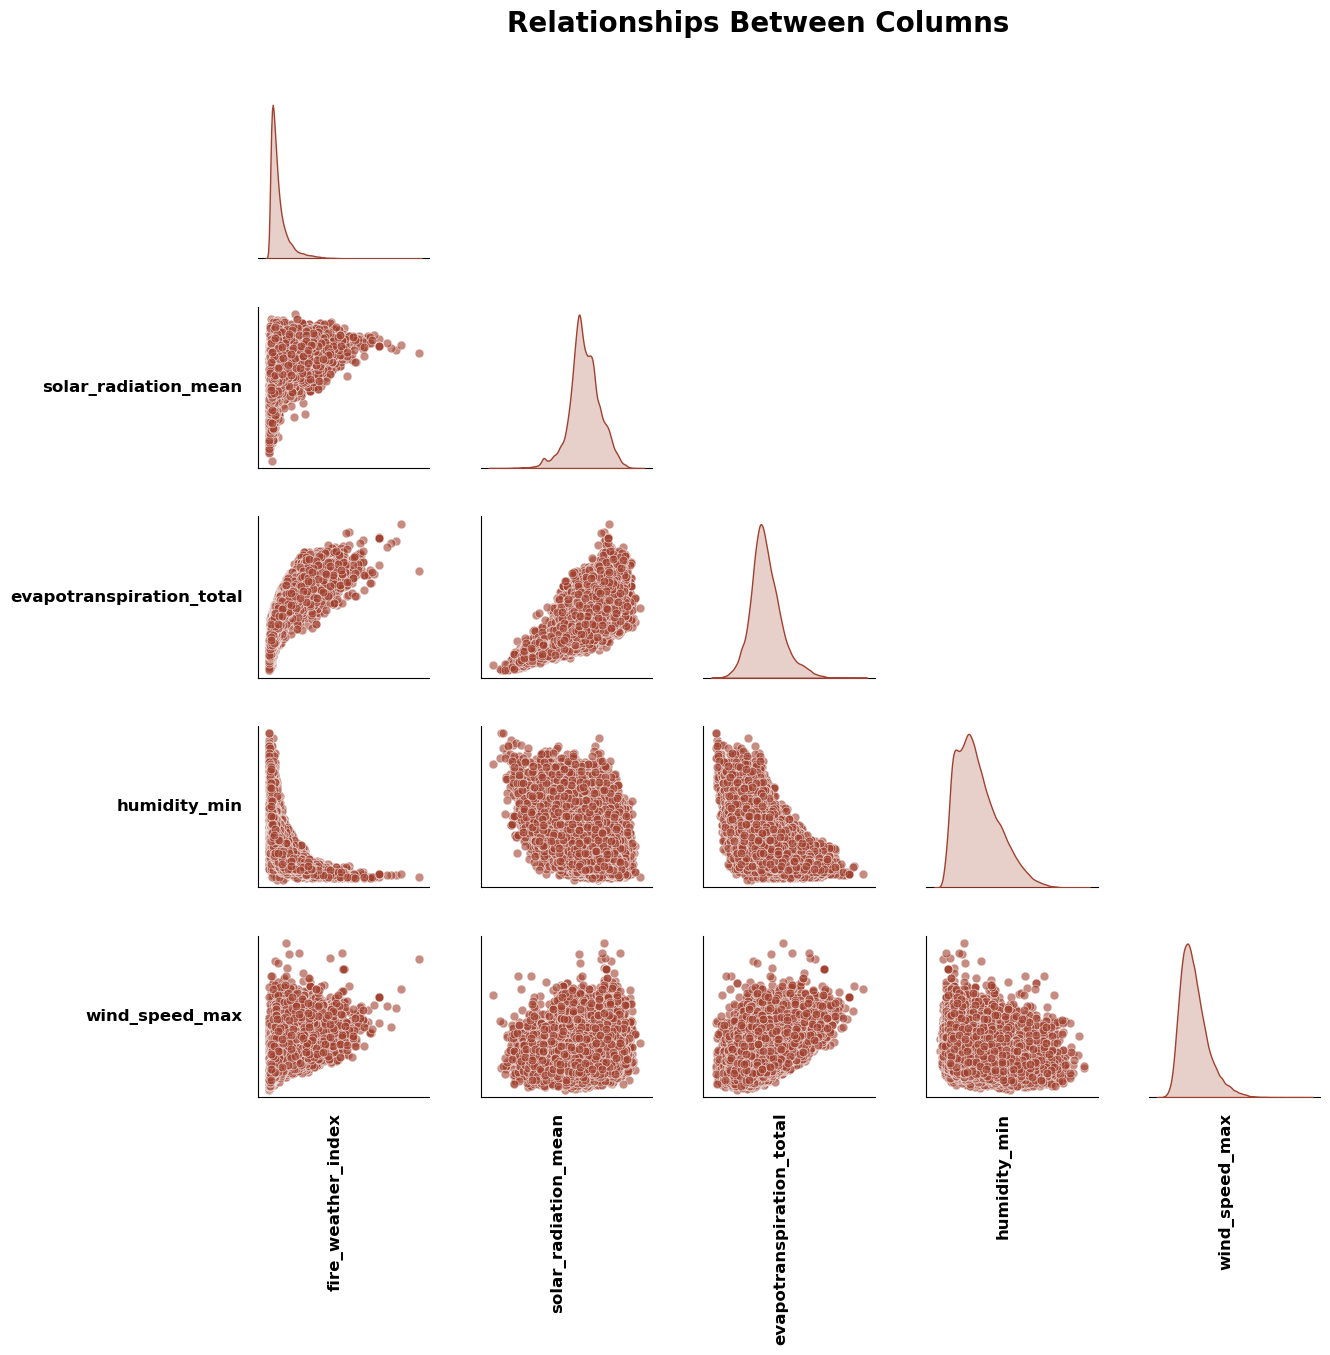

In [16]:
# set figure size
plt.figure(figsize=(20, 20))

# choose a pre-set style
#sns.set_theme(style="white", context="talk", font_scale=1.2)

# choose only some variables
cols = ["fire_weather_index",
        "solar_radiation_mean",
        "evapotranspiration_total",
        "humidity_min",
        "wind_speed_max",
        ]

color = "#A1402E"  # orange; try "#e6ab02" for yellow, "#8c6d31" for brown

g = sns.pairplot(
    data=df[cols],
    diag_kind="kde",
    corner=True,
    plot_kws={"alpha": 0.6, "s": 40, "color": color},   # scatter color
    diag_kws={"shade": True, "color": color}            # kde color
)

# # create pairplot
# g = sns.pairplot(data=df[cols],                     # select relevant columns
#                  diag_kind="kde",                   # set diagonals to KDE plots
#                  corner=True,                       # show lower triangle only
#                  palette = 'YlOrBr',
#                  plot_kws={"alpha": 0.6, "s": 40},  # softer, larger points
#                  diag_kws={"shade": True}           # add shading to diagonal graphs
#                 )

# add title for entire figure
g.fig.suptitle("Relationships Between Columns", fontsize=20, y=1.02, fontweight='bold')

# format labels to avoid overlapping
for ax in g.axes.flatten():
    if ax is not None:
        # Rotate x labels and align
        ax.set_xlabel(ax.get_xlabel(), fontsize=12, fontweight='semibold', rotation=90, ha='right')
        # Keep y labels vertical and aligned
        ax.set_ylabel(ax.get_ylabel(), fontsize=12, fontweight='semibold', rotation=0, ha='right', va='center')
        ax.set_xticklabels([])  # hide x-axis numbers
        ax.set_yticklabels([])  # hide y-axis numbers
        ax.tick_params(left=False, bottom=False)  # remove tick marks
        
# adjust spacing to prevent overlaps
g.fig.subplots_adjust(top=0.95, bottom=0.15, left=0.1, right=0.95, hspace=0.3, wspace=0.3)

# Optional: save figure
#plt.savefig('pairplot.png', dpi=300, bbox_inches='tight')

# display the chart
plt.show()

Based on the pairplot, we can transform the columns that show logarithmic relationships.

In [17]:
# create copy of dataframe
df_log = df.copy()

# Select columns we want to transform
log_cols = [
    "fire_weather_index",
    "wind_direction_std",
    "solar_radiation_mean",
    "evapotranspiration_total",
    "humidity_min",
    "temp_range",
    "wind_speed_max"
]

# Apply log transformation on dataframe
df_log[log_cols] = np.log1p(df_log[log_cols])

Now we can investigate correlations. 

First we can investigate which columns had the highest correlations with the target.

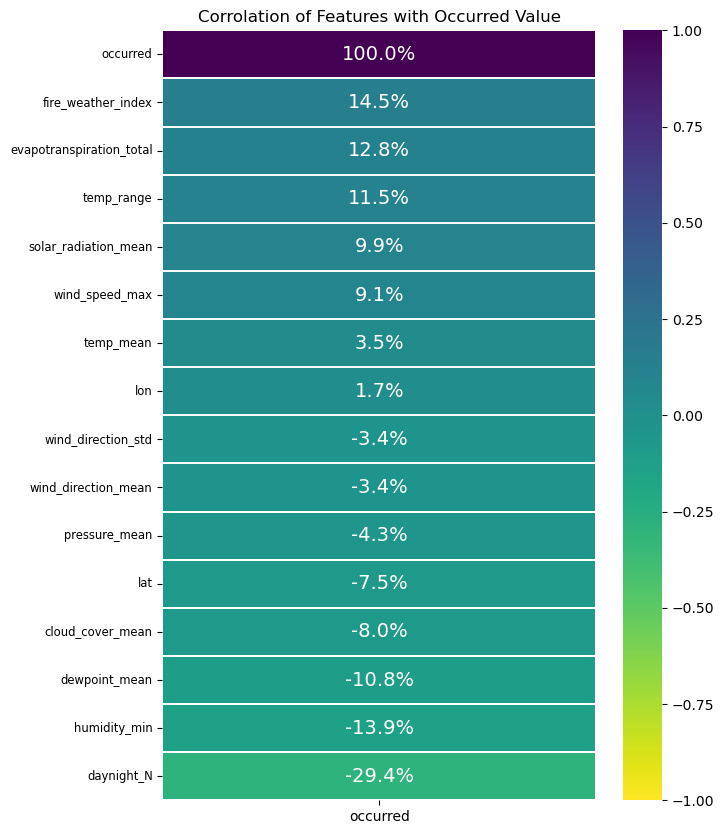

In [18]:
# Set figure size
plt.figure(figsize = (7, 10))

# Calculate the correlation matrix
corr_o = df_log.corr()

# Show only the correlations with 'occurred' column
# Sort by highest correlation
occurred_corr = corr_o[['occurred']].sort_values(by='occurred',ascending=False)

# Plot the matrix as a heatmap
sns.heatmap(occurred_corr,
            annot = True,                 # adding labels
            annot_kws={"fontsize":14},    # adjusting font size
            fmt = '.1%',                  # rounding
            vmin = -1,                    # set minimum limit
            vmax = +1,                    # set maximum limit
            cmap = 'viridis_r',              # set colour map
            linewidths=0.1,               # adding whitespace for readability
           )

plt.yticks(fontsize = 'small')

# Add title
plt.title('Corrolation of Features with Occurred Value')

# Save figure
# plt.savefig('occurred_correlations.png', dpi=300, bbox_inches='tight')


plt.show()

Next we can investigate the correlations between columns to investigate collinearity.

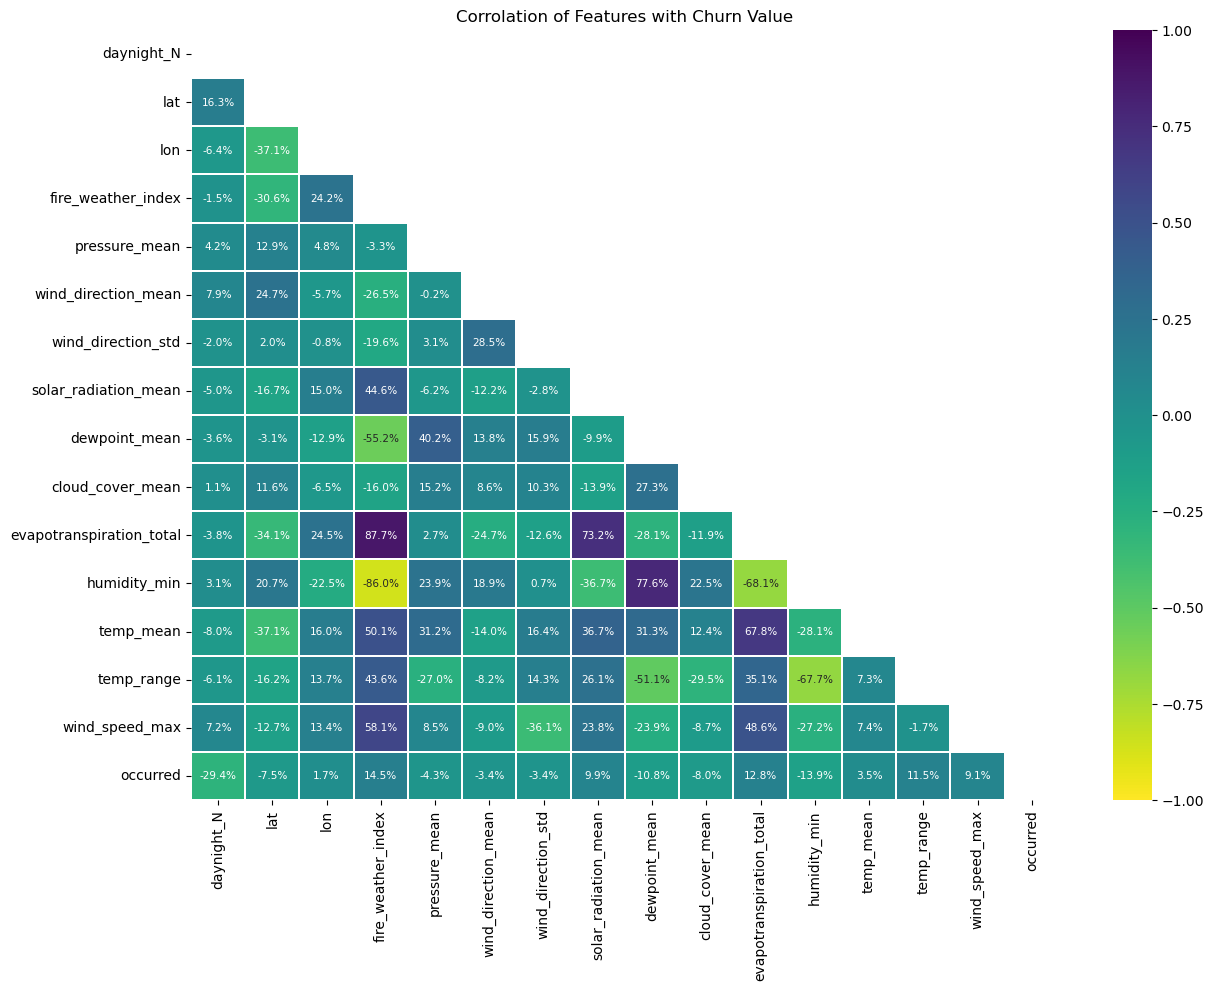

In [19]:
# set figure size
plt.figure(figsize = (14, 10))

# calculate correlations
corr_m = df_log.corr()

# Show only lower half
mask1 = np.triu(corr_m)

# Plot the matrix as a heatmap
sns.heatmap(corr_m,
            annot = True,                 # adding labels
            annot_kws={"fontsize":7.5},   # adjusting font size
            fmt = '.1%',                  # rounding
            vmin = -1,                    # set minimum limit
            vmax = +1,                    # set maximum limit
            cmap = 'viridis_r',           # set colour map
            linewidths=0.1,               # adding whitespace for readability
            mask = mask1                  # apply mask
           )

# Display the matrix
plt.title('Corrolation of Features with Churn Value')

plt.show()

In [20]:
## Talk about correlations

Now we can create two separate copies on the dataframe so far, and explore two different pipelines for the model.

In [21]:
df_A = df_log.copy()
df_B = df_log.copy()
df_C = df_log.copy()

---

# <u>PIPELINE A: Dropping columns based on collinearity</u>

We can show the correlations for columns that had a correlation higher than ±0.7.

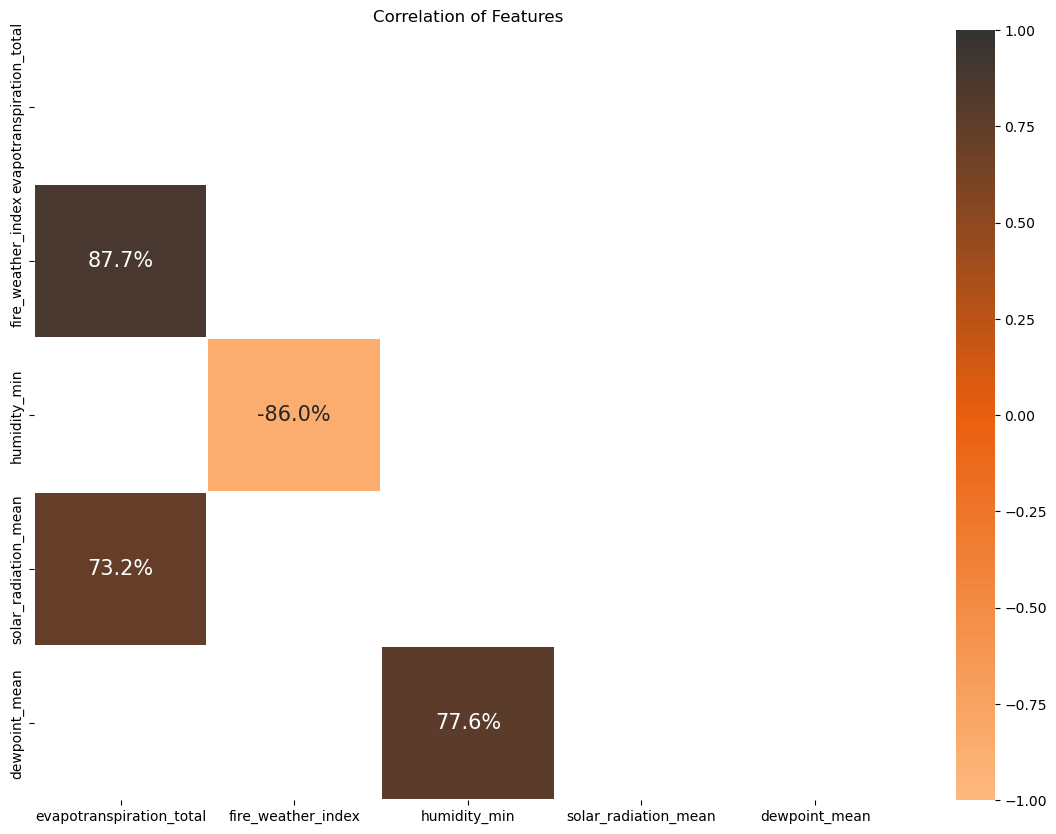

In [22]:
# set figure size
plt.figure(figsize = (14, 10))

# select only relevant columns
cols2 = ['evapotranspiration_total', 'fire_weather_index', 'humidity_min', 'solar_radiation_mean', 'dewpoint_mean']

# calculate correlations
corr_m = df_log[cols2].corr()

# Show only lower half
mask1 = np.triu(corr_m)
# Show only correlations greater than ±0.7
mask2 = np.abs(corr_m) <= 0.7
# Combine the masks
combined_mask = mask1|mask2

# Plot the matrix as a heatmap
sns.heatmap(corr_m,
            annot = True,                 # adding labels
            annot_kws={"fontsize":15},   # adjusting font size
            fmt = '.1%',                  # rounding
            vmin = -1,                    # set minimum limit
            vmax = +1,                    # set maximum limit
            cmap = sns.color_palette("Oranges_d", as_cmap=True),              # set colour map
            linewidths=0.1,               # adding whitespace for readability
            mask = combined_mask          # apply combined mask
           )

# Add title
plt.title('Correlation of Features')

# Save figure
#plt.savefig('features_correlations_reduced.png', dpi=300, bbox_inches='tight')

plt.show()

We can investigate the following relationships, as these columns have a correlation > 0.7 (or < -0.7)

* **fire_weather_index** and **evapotranspiration_total**
    * 87.7%  
    
    
* **fire_weather_index** and **humidity_min**
    * -86.0%  
    

* **evapotranspiration_total** and **solar_radiation_mean**
    * 73.2%  
    

* **humidity_min** and **dewpoint_mean**
    * 77.6%  
    

## VIF Scores



Calculate VIF for pairs of columns:

In [23]:
features1 = df_A[['fire_weather_index', 'evapotranspiration_total']]
vif_data1 = pd.DataFrame()
vif_data1['features'] = features1.columns
vif_data1['VIF'] = [variance_inflation_factor(features1.values, i) for i in range(features1.shape[1])]
display(vif_data1)

features2 = df_A[['fire_weather_index', 'humidity_min']]
vif_data2 = pd.DataFrame()
vif_data2['features'] = features2.columns
vif_data2['VIF'] = [variance_inflation_factor(features2.values, i) for i in range(features2.shape[1])]
display(vif_data2)

features3 = df_A[['evapotranspiration_total', 'solar_radiation_mean']]
vif_data3 = pd.DataFrame()
vif_data3['features'] = features3.columns
vif_data3['VIF'] = [variance_inflation_factor(features3.values, i) for i in range(features3.shape[1])]
display(vif_data3)

features4 = df_A[['humidity_min', 'dewpoint_mean']]
vif_data4 = pd.DataFrame()
vif_data4['features'] = features4.columns
vif_data4['VIF'] = [variance_inflation_factor(features4.values, i) for i in range(features4.shape[1])]
display(vif_data4)

,features,VIF
0,fire_weather_index,27.096471
1,evapotranspiration_total,27.096471


,features,VIF
0,fire_weather_index,5.200315
1,humidity_min,5.200315


,features,VIF
0,evapotranspiration_total,85.695227
1,solar_radiation_mean,85.695227


,features,VIF
0,humidity_min,3.228796
1,dewpoint_mean,3.228796


The cutoff for VIF score is usually anything above 10. 

We see that fire_weather_index and evapotranspiration_total have a VIF of 27, so we will drop one of these columns. 

We also see that evapotranspiration_total and solar_radiation_mean have a VIF of 85, so we will drop one of these columns. 

Now we can calculate VIF for all columns:

In [24]:
# Calculating the VIF for all columns (except one-hot-encoded)
# i.e. columns with index 0 to 15
features5 = df_A

vif_data_drop = pd.DataFrame()
vif_data_drop['features'] = features5.columns
vif_data_drop['VIF'] = [variance_inflation_factor(features5.values, i) for i in range(features5.shape[1])]

# Display the VIF for each column in descending order
vif_data_drop = vif_data_drop.sort_values(by='VIF', ascending=False)
display(vif_data_drop)

,features,VIF
7,solar_radiation_mean,2115.052563
10,evapotranspiration_total,1034.076599
4,pressure_mean,615.844182
11,humidity_min,481.514151
14,wind_speed_max,360.537148
3,fire_weather_index,341.400122
13,temp_range,312.978268
12,temp_mean,250.296319
6,wind_direction_std,32.832730
8,dewpoint_mean,22.233949


We see that **solar_radiation_mean**, **evapotranspiration_mean** and **fire_weather_index** all have high VIFs, so we will keep one out of these three.  

The **fire_weather_index** column is most useful in the predictive model, so we drop the other two.  

In [25]:
df_A.drop(columns = ['evapotranspiration_total', 'solar_radiation_mean'], inplace = True)

## Train-Test-Split

In [26]:
# define feature columns
    # we will not be using the 'frp' column as a feature
    # as it does not make sense in our predictive model
X_A = df_A.drop(['occurred'], axis=1)

# define target column
y_A = df_A['occurred']

# Perform the split and assign to the corresponding variables
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A, 
                                                            y_A, 
                                                            test_size = 0.2,        # set test_size to 20%
                                                            random_state = 100,     # fix the random state to a random number
                                                            stratify = y_A          # stratify the data
                                                           )

## XGBoost Model A

In [27]:
def objective_A(trial):

    # set hyperparameters to tune
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "tree_method": "hist",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "lambda": trial.suggest_float("lambda", 1e-8, 5),
        "alpha": trial.suggest_float("alpha", 1e-8, 5),
        "n_estimators": trial.suggest_int("n_estimators", 200, 1200)
    }

    # initialise the model with the parameters
    model = XGBClassifier(**params)

    # define the 5-fold validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # define recall scorer for cross_val_score
    recall = metrics.make_scorer(metrics.recall_score)

    # calculate cross validation recall score
    scores = cross_val_score(model,
                             X_train_A,
                             y_train_A,
                             cv=cv,
                             scoring=recall
                            )

    # return the mean score of the 5 folds
    return scores.mean()

In [28]:
# only show warnings and errors
optuna.logging.set_verbosity(optuna.logging.WARNING)

# perform the optimisation
study_A = optuna.create_study(direction="maximize")
study_A.optimize(objective_A, n_trials=50)

In [29]:
# get the best parameters from the optimisation
best_params_A = study_A.best_params

# Train a final model using best parameters
model_A = XGBClassifier(**best_params_A)

# fit to train data
model_A.fit(X_train_A, y_train_A)

XGBClassifier(alpha=0.6231017943551779, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9338532058627114, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=4.703890218363415,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.6728795742833915,
              learning_rate=0.024996059342912578, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1187, n_jobs=None, ...)

---
Evaluate on Train Data:

In [30]:
# calculate probabilities
train_probs_A = model_A.predict_proba(X_train_A)[:, 1]

# set threshold to 0.4
threshold = 0.4

# make predictions
train_preds_A = (train_probs_A >= threshold).astype(int)

# calculate recall
metrics.recall_score(y_train_A, train_preds_A)

0.9276005722942265

Evaluate on Test Data:

In [31]:
# calculate probabilities
test_probs_A = model_A.predict_proba(X_test_A)[:, 1]

# set threshold to 0.4
threshold = 0.4

# make predictions
test_preds_A = (test_probs_A >= threshold).astype(int)

# calculate recall
metrics.recall_score(y_test_A, test_preds_A)

0.921309543847837

---

# <u>PIPELINE B: Dropping columns via PCA</u>  

Now we can create a model that drops features based on PCA.

## Train-Test-Split

In [32]:
# define feature columns
    # we will not be using the 'frp' column as a feature
    # as it does not make sense in our predictive model
X_B = df_B.drop(['occurred'], axis=1)

# define target column
y_B = df_B['occurred']

# Perform the split and assign to the corresponding variables
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B, 
                                                            y_B, 
                                                            test_size = 0.2,        # set test_size to 20%
                                                            random_state = 100,     # fix the random state to a random number
                                                            stratify = y_B          # stratify the data
                                                           )

## Baseline Model

In [33]:
# fit the model to training data
base_model = XGBClassifier()
base_model.fit(X_train_B, y_train_B)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [34]:
# make prediction on train data
y_pred_B = base_model.predict(X_train_B)
metrics.recall_score(y_train_B, y_pred_B)

0.8105748190540313

In [35]:
# make prediction on test data
y_test_pred_B = base_model.predict(X_test_B)
metrics.recall_score(y_test_B, y_test_pred_B)

0.7448241036862481

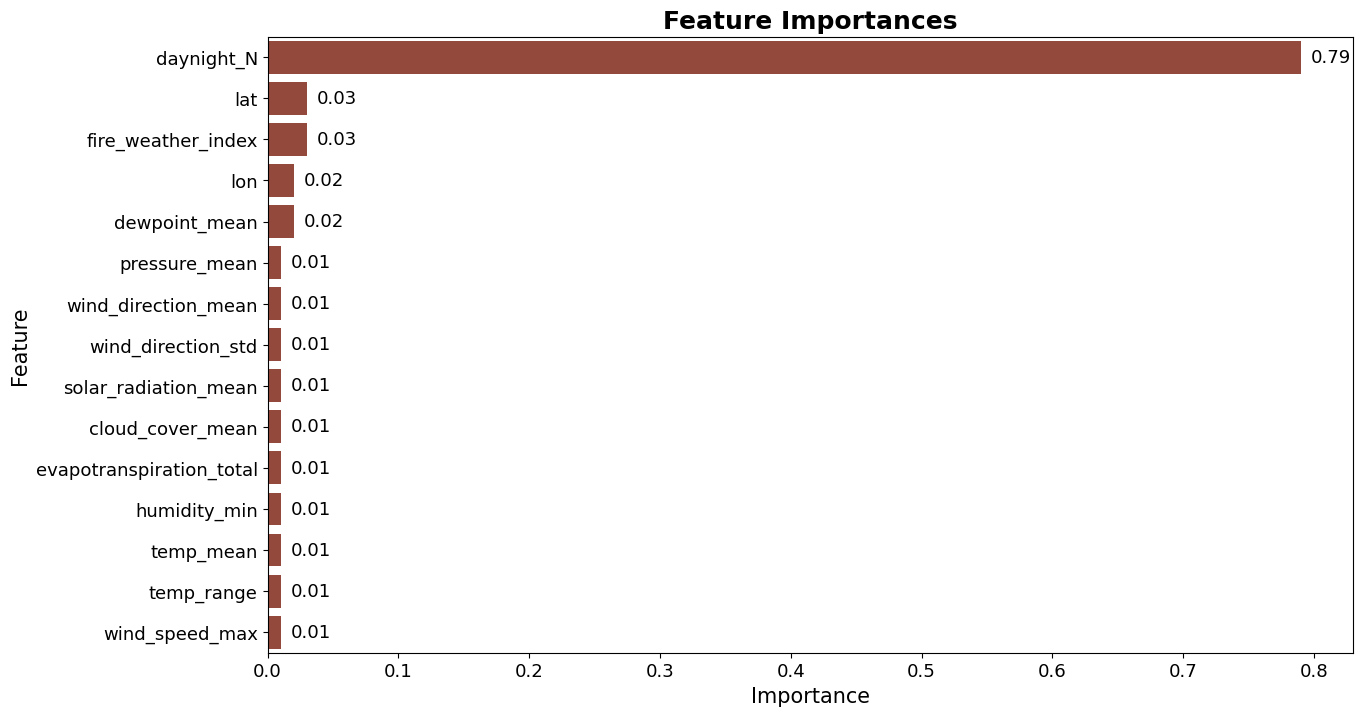

In [36]:
# get feature importances (normalized)
importance_df = pd.DataFrame({
    'Feature': X_train_B.columns,               # actual column names
    'Importance': base_model.feature_importances_
})

# round to 2 decimals
importance_df['Importance'] = importance_df['Importance'].round(2)

# sort descending
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# plot
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    x='Importance',
    y='Feature',
    data=importance_df,
    color='#A1402E',
)

# add rounded numbers on bars
for p in ax.patches:
    width = p.get_width()
    ax.text(
        width + max(importance_df['Importance'])*0.01,  # small offset
        p.get_y() + p.get_height() / 2,
        f"{width:.2f}",                                  # 2 decimals
        va='center', fontsize=13
    )

# customize labels & title
ax.set_title('Feature Importances', fontsize=18, fontweight='bold')
ax.set_xlabel('Importance', fontsize=15)
ax.set_ylabel('Feature', fontsize=15)
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)
ax.grid(False)

plt.savefig('feature_importances.png', dpi=300, bbox_inches='tight')

plt.show()


## Scaling

Scale features to prepare for PCA

In [37]:
# Scale all feature columns

# initialise scaler
scaler = StandardScaler()

# fit on train data and transform
X_train_scaled = scaler.fit_transform(X_train_B)
# save as a dataframe with original column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train_B.columns)

# transform the test data
X_test_scaled = scaler.transform(X_test_B)
# save as a dataframe with original column names
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test_B.columns)

## PCA

In [38]:
# initialise PCA
pca = PCA(n_components=0.95)  # set number of components to 
                              # whatever retains 95% of variance in the data

# fit PCA on the train data, then transform it to principal components
X_train_pca = pca.fit_transform(X_train_scaled)
# save as dataframe
X_train_pca = pd.DataFrame(X_train_pca)

# transform the test data to principal components
X_test_pca = pca.transform(X_test_scaled)
# save as dataframe
X_test_pca = pd.DataFrame(X_test_pca)

## XGBoost Model B

In [39]:
def objective_B(trial):

    # set hyperparameters to tune
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "tree_method": "hist",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "lambda": trial.suggest_float("lambda", 1e-8, 5),
        "alpha": trial.suggest_float("alpha", 1e-8, 5),
        "n_estimators": trial.suggest_int("n_estimators", 200, 1200)
    }

    # initialise the model with the parameters
    model = XGBClassifier(**params)

    # define the 5-fold validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # define recall scorer for cross_val_score
    recall = metrics.make_scorer(metrics.recall_score)

    # calculate cross validation recall score
    scores = cross_val_score(model,
                             X_train_pca,
                             y_train_B,
                             cv=cv,
                             scoring=recall
                            )

    # return the mean score of the 5 folds
    return scores.mean()

In [40]:
# perform the optimisation
study_B = optuna.create_study(direction="maximize")
study_B.optimize(objective_B, n_trials=50)

In [41]:
# get the best parameters from the optimisation
best_params_B = study_B.best_params

# Train a final model using best parameters
model_B = XGBClassifier(**best_params_B)

# fit to train data
model_B.fit(X_train_pca, y_train_B)

XGBClassifier(alpha=4.289298388386696, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5440968496781247, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.47258162460175956,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=2.562412759445487,
              learning_rate=0.010440188650911703, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=210, n_jobs=None, ...)

Evaluate on Train Data:

In [42]:
# calculate probabilities
train_probs_B = model_B.predict_proba(X_train_pca)[:, 1]

# set threshold to 0.4
threshold = 0.4

# make predictions
train_preds_B = (train_probs_B >= threshold).astype(int)

# calculate recall
metrics.recall_score(y_train_B, train_preds_B)

0.9608020535263424

Evaluate on Test Data:

In [43]:
# calculate probabilities
test_probs_B = model_B.predict_proba(X_test_pca)[:, 1]

# set threshold to 0.4
threshold = 0.4

# make predictions
test_preds_B = (test_probs_B >= threshold).astype(int)

# calculate recall
metrics.recall_score(y_test_B, test_preds_B)

0.962800875273523

In [44]:
print(metrics.classification_report(y_test_B, test_preds_B))

              precision    recall  f1-score   support

         0.0       0.86      0.23      0.37     11850
         1.0       0.56      0.96      0.71     11882

    accuracy                           0.60     23732
   macro avg       0.71      0.60      0.54     23732
weighted avg       0.71      0.60      0.54     23732



# <u>FUNCTION</u>

In [45]:
# function that takes inputs from the user
# takes column name as input
def ask_value(name):
    
    while True:
    
        try:
            # prints "Enter 'column name': "
            # takes input as a float
            # stores and returns the value inputted
            val = float(input(f"Enter {name}: "))
            return val
        
        except ValueError:
            
            # if input is not a float, prints the error message
            print("Invalid input — please enter a number.")


# function that takes array of column names as an input
# then collects and stores user inputted values for these columns
def collect_inputs_safe(feature_names):
    
    # documentation
    """
    Asks user for each feature value and returns a one-row DataFrame.
    """
    
    # create empty dictionary
    data = {}

    # loop through each feature
    for name in feature_names:
        # take the input for this feature using the ask_value function
        # stores as a key:value pair in the 'data' dictionary
        data[name] = ask_value(name)

    # create (and return) a dataframe from the dictionary
    return pd.DataFrame([data])

In [46]:
# function that creates a prediction using the model
def wildfire_predictor():
    
    # when initialised, prints the title
    print("\n--- Wildfire Prediction Input ---\n")
    
    # define the model
    model = model_B

    # get inputs from user
    # save as dataframe
    # set columns equal to those of X_train
    df = collect_inputs_safe(X_train_B.columns)
    
    # apply log transformations
    df[log_cols] = np.log1p(df[log_cols])
    
    # apply scaling
    df_scaled = pd.DataFrame(scaler.transform(df), columns = X_train_B.columns)
    
    # apply PCA
    df_pca = pd.DataFrame(pca.transform(df_scaled))

    # calculate probability on inputted data
    proba = model.predict_proba(df_pca)[0, 1]
    # make prediction based on 40% threshold
    pred = int(proba > 0.4)
    
    # formatting
    print("\n ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ \n")
    
    # if no wildfire is predicted by the model, print the message
    if pred == 0:
        print(f"It is not likely that a wildfire will occur based on the details entered.")
    
    # if a wildfire is predicted by the model, print the message
    else:
        print("It is likely that a wildfire will occur.")
        print("GUIDANCE: Get to a safe place immediately, call 999, and do not attempt to fight the fire yourself.")
    
    # regardless of the prediction, print the probability calculated
    print("\n ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ \n")
    print(f"The probability of a wildfire starting based on the conditions entered is {proba:.4f}")
    print("\n ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ \n")

    # return nothing
    return


In [47]:
# use the function
# wildfire_predictor()

# Locally Hosted Website

We can use the 'Streamlit' library to create a locally hosted website which uses our model.  

In order to do this, we must first save the model, and any other objects that are required (scaler and pca objects in this case).

In [48]:
# # save the final model as a pkl file
# # closes when done
# with open("model.pkl", "wb") as f:
#     pickle.dump(model_B, f)

In [49]:
# # save the pca object
# with open("scaler.pkl", "wb") as f:
#     pickle.dump(scaler, f)

In [50]:
# # save the pca object
# with open("pca.pkl", "wb") as f:
#     pickle.dump(pca, f)

These created files should now be moved into the same folder as the 'app.py' file. They can then be loaded and used in the 'app.py' file to create the locally hosted website.   

Once the app.py file has been created, it should be run as follows:  
* Open terminal  
* Run the commands:  
    * cd ~/Desktop/df/projects/capstone/xgb_app         (or whatever the path to the file is)
    * conda activate streamlit  
    * streamlit run app.py

# <u>REFERENCES</u>

Link to Dataset:  
https://www.kaggle.com/datasets/vijayaragulvr/wildfire-prediction  


Calculating VIF Scores:  
https://www.geeksforgeeks.org/python/detecting-multicollinearity-with-vif-python/


Creating Basic XGBoost Model:  
https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/  


Explanation of Parameter Tuning:  
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/   


Using Optuna:  
https://www.bswr.io/posts/xgboost_optuna/  


Stratified K Fold:  
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html  


Streamlit Documentation:  
https://docs.streamlit.io/